In [1]:
import os
import pandas as pd
import networkx as nx

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [28]:
path = "data\\harvard\\HXPC13_DI_v3_11-13-2019.csv"

In [3]:
data = pd.read_csv(path)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338223 entries, 0 to 338222
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   course_id          338223 non-null  object 
 1   userid_DI          338223 non-null  object 
 2   registered         338223 non-null  int64  
 3   viewed             338223 non-null  int64  
 4   explored           338223 non-null  int64  
 5   certified          338223 non-null  int64  
 6   final_cc_cname_DI  338223 non-null  object 
 7   LoE_DI             294104 non-null  object 
 8   YoB                299719 non-null  float64
 9   gender             305262 non-null  object 
 10  grade              312333 non-null  object 
 11  start_time_DI      338223 non-null  object 
 12  last_event_DI      185992 non-null  object 
 13  nevents            178945 non-null  float64
 14  ndays_act          195713 non-null  float64
 15  nplay_video        33277 non-null   float64
 16  nc

In [5]:
data.head()

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts,roles,incomplete_flag
0,HarvardX/CB22x/2013_Spring,MHxPC130442623,1,0,0,0,United States,NaN,NaN,NaN,0,12/19/12,11/17/13,NaN,9.0,NaN,NaN,0,NaN,1.0
1,HarvardX/CB22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2/8/13,11/17/13,NaN,16.0,NaN,NaN,0,NaN,1.0
2,HarvardX/CB22x/2013_Spring,MHxPC130539455,1,1,0,0,France,NaN,NaN,NaN,0,1/1/13,5/14/13,42.0,6.0,NaN,3.0,0,NaN,NaN
3,HarvardX/CB22x/2013_Spring,MHxPC130088379,1,1,0,0,United States,NaN,NaN,NaN,0,2/18/13,3/17/13,70.0,3.0,NaN,3.0,0,NaN,NaN
4,HarvardX/CB22x/2013_Spring,MHxPC130024894,1,1,0,0,United States,NaN,NaN,NaN,0.07,1/24/13,8/3/13,175.0,9.0,NaN,7.0,0,NaN,NaN


## userid

explor the number of interactions of users in the dataset

In [ ]:
data.__len__()

338223

In [ ]:
data.userid_DI.nunique()

301609

In [27]:
print("number of interaction per user in harvard dataset : ", data.__len__() / data.userid_DI.nunique())

number of interaction per user in harvard dataset :  1.1213955816968326


In [ ]:
data.userid_DI.value_counts().head()

userid_DI
MHxPC130506390    5
MHxPC130314286    5
MHxPC130223277    5
MHxPC130362373    5
MHxPC130478289    5
Name: count, dtype: int64

### notes
- the number of interaction per user is too low 

## course_id

In [8]:
data.course_id.unique()

array(['HarvardX/CB22x/2013_Spring', 'HarvardX/CS50x/2012',
       'HarvardX/ER22x/2013_Spring', 'HarvardX/PH207x/2012_Fall',
       'HarvardX/PH278x/2013_Spring'], dtype=object)

## explor null distribution

<Axes: >

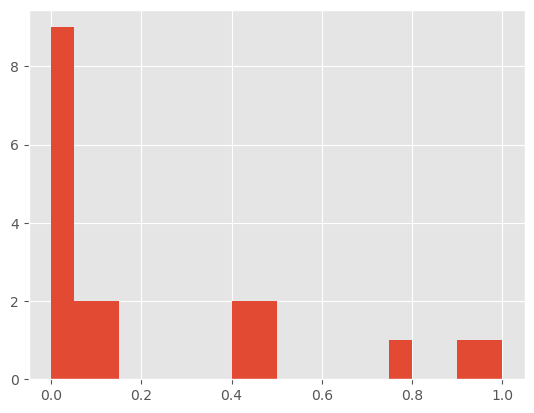

In [9]:
null_dist = data.isna().mean()
null_dist.hist(bins=20)

## explor these columns
- last_event_DI
- nevents
- ndays_act
- nplay_video
- nchapters
- roles
- incomplete_flag

<Axes: >

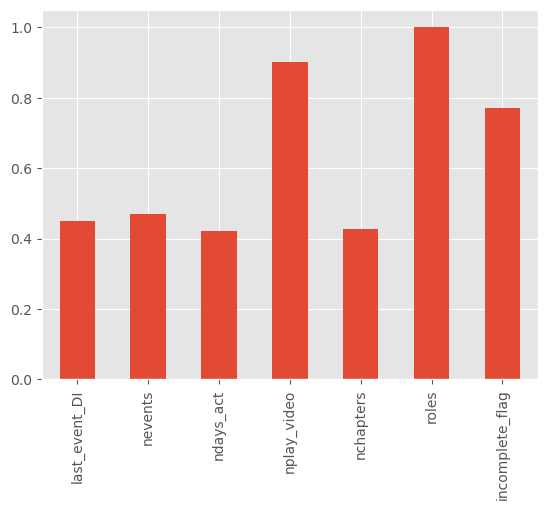

In [10]:
null_dist = null_dist[null_dist > 0.4]
null_dist.plot(kind='bar')

In [11]:
data.incomplete_flag.value_counts()

incomplete_flag
1.0    77385
Name: count, dtype: int64

### first impresion on incomplete_flag
- if the user leave the course for (period of time) we will flag him 
- otherwise we will leave it null

### first impresion on roles
- it's may indecat of the user role like : "instructor", "teaching assistant", or "admin" 
- but as it completely null, we may drop just it 

In [31]:
data.nevents.nunique()

5133

In [13]:
data['start_time_DI'] =  pd.to_datetime(data['start_time_DI'])
data['last_event_DI'] =  pd.to_datetime(data['last_event_DI'])

C:\Users\jehad\AppData\Local\Temp\ipykernel_18424\2618166311.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['start_time_DI'] =  pd.to_datetime(data['start_time_DI'])
C:\Users\jehad\AppData\Local\Temp\ipykernel_18424\2618166311.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['last_event_DI'] =  pd.to_datetime(data['last_event_DI'])


In [14]:
data.last_event_DI.isna().sum()

152231

In [15]:
temp = data[null_dist.index.values].copy()

In [16]:
temp['last_event_DI'] = pd.to_datetime(temp['last_event_DI'])
# temp = temp.drop(columns=['roles', 'incomplete_flag'], axis=1)

In [17]:
temp['last_event_DI'].mean()

Timestamp('2013-04-17 22:18:42.009548800')

In [18]:
temp.corr()

,last_event_DI,nevents,ndays_act,nplay_video,nchapters,roles,incomplete_flag
last_event_DI,1.000000,0.014327,-0.055452,-0.008534,0.253192,NaN,NaN
nevents,0.014327,1.000000,0.718681,0.814174,0.444501,NaN,NaN
ndays_act,-0.055452,0.718681,1.000000,0.625898,0.607456,NaN,NaN
nplay_video,-0.008534,0.814174,0.625898,1.000000,0.500819,NaN,NaN
nchapters,0.253192,0.444501,0.607456,0.500819,1.000000,NaN,NaN
roles,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incomplete_flag,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### first impresion on other columns
#### value corr
these columns
- nevents	
- ndays_act
- nplay_video
- nchapters   
all of these have high correlation between them which make sense 

In [19]:
temp[temp.columns] = temp[temp.columns].isna()
temp[temp.columns] = temp[temp.columns].astype(int)

In [20]:
temp.corr()

,last_event_DI,nevents,ndays_act,nplay_video,nchapters,roles,incomplete_flag
last_event_DI,1.000000,0.958929,0.874306,0.298858,0.263502,NaN,-0.582110
nevents,0.958929,1.000000,0.904471,0.311638,0.309690,NaN,-0.577331
ndays_act,0.874306,0.904471,1.000000,0.281886,0.254478,NaN,-0.399286
nplay_video,0.298858,0.311638,0.281886,1.000000,0.285201,NaN,-0.179906
nchapters,0.263502,0.309690,0.254478,0.285201,1.000000,NaN,0.299543
roles,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incomplete_flag,-0.582110,-0.577331,-0.399286,-0.179906,0.299543,NaN,1.000000


In [21]:
data[data['userid_DI'] == 'MHxPC130506390'].sort_values(by='start_time_DI')

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts,roles,incomplete_flag
34093,HarvardX/CS50x/2012,MHxPC130506390,1,1,0,0,United States,NaN,NaN,NaN,0,2012-08-06,NaT,NaN,2.0,NaN,2.0,0,NaN,1.0
257524,HarvardX/PH207x/2012_Fall,MHxPC130506390,1,0,0,0,United States,NaN,NaN,NaN,0,2012-08-06,2012-12-31,4.0,2.0,NaN,NaN,0,NaN,NaN
700,HarvardX/CB22x/2013_Spring,MHxPC130506390,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-28,2013-11-17,NaN,2.0,NaN,NaN,0,NaN,1.0
200592,HarvardX/ER22x/2013_Spring,MHxPC130506390,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-28,NaT,NaN,2.0,NaN,NaN,0,NaN,1.0
299132,HarvardX/PH278x/2013_Spring,MHxPC130506390,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-28,NaT,NaN,2.0,NaN,NaN,0,NaN,1.0


#### null corr

- we also notice that they also have high correlation between "the null "
- what i mean by that is : "when on is null the other have high possibility to be null"